<a href="https://colab.research.google.com/github/vinhpeters/tf-exam/blob/main/06_transfer_learning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scaling up Transfer Learning Models

## Import helper functions

In [7]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [8]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, walk_through_dir, unzip_data


## 101 Food Classes

In [9]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

In [2]:
unzip_data('101_food_classes_10_percent.zip')

In [3]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [4]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [5]:
import tensorflow as tf

IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
checkpoint_path = '101_classes_10_percent_data_model_checpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_weights_only=True, save_best_only=True)

In [10]:
# Data augmentation layers
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
], name='data_augmentation')


In [11]:

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


inputs = layers.Input(shape=(224,224,3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)



In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [13]:
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [14]:
history=model.fit(train_data_all_10_percent, epochs = 5 , steps_per_epoch= len(train_data_all_10_percent), validation_data=test_data, validation_steps = 0.15 * len(test_data), callbacks =[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 120s 471ms/step - loss: 3.3575 - accuracy: 0.2762 - val_loss: 2.4819 - val_accuracy: 0.4530
Epoch 2/5
237/237 [==============================] - 111s 469ms/step - loss: 2.1962 - accuracy: 0.4985 - val_loss: 2.0475 - val_accuracy: 0.5150
Epoch 3/5
237/237 [==============================] - 109s 458ms/step - loss: 1.8169 - accuracy: 0.5702 - val_loss: 1.8659 - val_accuracy: 0.5399
Epoch 4/5
237/237 [==============================] - 109s 460ms/step - loss: 1.6174 - accuracy: 0.6157 - val_loss: 1.7990 - val_accuracy: 0.5444
Epoch 5/5
237/237 [==============================] - 110s 465ms/step - loss: 1.4542 - accuracy: 0.6397 - val_loss: 1.7654 - val_accuracy: 0.5410


In [15]:
results=model.evaluate(test_data)

790/790 [==============================] - 62s 78ms/step - loss: 1.5861 - accuracy: 0.5840


## Fine-tuning

In [16]:
base_model.trainable = True

In [17]:
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [19]:
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [20]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10
history_all_fine = model.fit(train_data_all_10_percent, epochs = fine_tune_epochs , steps_per_epoch= len(train_data_all_10_percent), validation_data=test_data, validation_steps = 0.15 * len(test_data), initial_epoch = history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 114s 449ms/step - loss: 1.2093 - accuracy: 0.6795 - val_loss: 1.7304 - val_accuracy: 0.5420
Epoch 6/10
237/237 [==============================] - 109s 457ms/step - loss: 1.0926 - accuracy: 0.7084 - val_loss: 1.7341 - val_accuracy: 0.5436
Epoch 7/10
237/237 [==============================] - 107s 450ms/step - loss: 1.0239 - accuracy: 0.7220 - val_loss: 1.7184 - val_accuracy: 0.5499
Epoch 8/10
237/237 [==============================] - 105s 444ms/step - loss: 0.9433 - accuracy: 0.7481 - val_loss: 1.7004 - val_accuracy: 0.5554
Epoch 9/10
237/237 [==============================] - 105s 443ms/step - loss: 0.8960 - accuracy: 0.7596 - val_loss: 1.7327 - val_accuracy: 0.5509
Epoch 10/10
237/237 [==============================] - 104s 438ms/step - loss: 0.8333 - accuracy: 0.7787 - val_loss: 1.7501 - val_accuracy: 0.5470


In [21]:
fine_tuned_results=model.evaluate(test_data)

790/790 [==============================] - 63s 79ms/step - loss: 1.5027 - accuracy: 0.6023


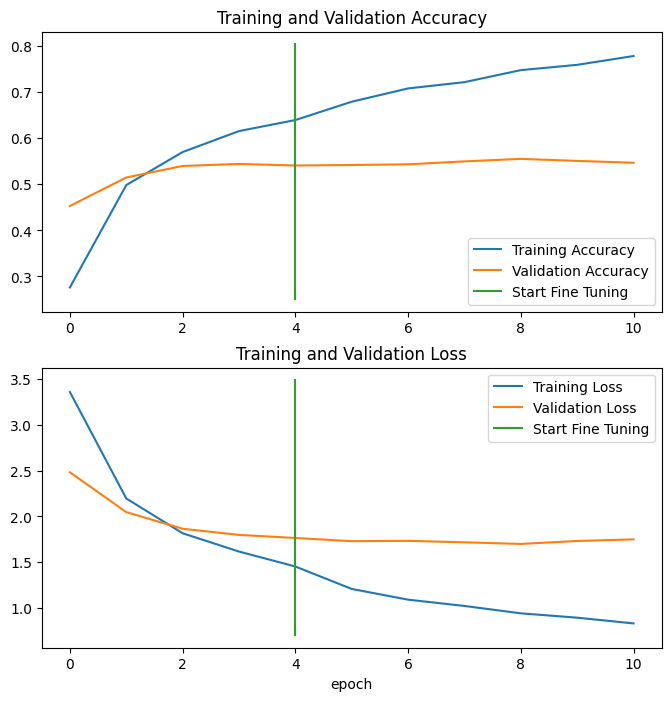

In [22]:
compare_historys(history,history_all_fine)

In [23]:
try:
  model.save('drive/MyDrive/101_food_classes_efficient')
  loaded_model = tf.keras.models.load_model('drive/MyDrive/101_food_classes_efficient')
except:
  print('Saving failed')

INFO:tensorflow:Assets written to: drive/MyDrive/101_food_classes_efficient\assets


INFO:tensorflow:Assets written to: drive/MyDrive/101_food_classes_efficient\assets


Saving failed


## Loading pre-trained model

In [24]:
import tensorflow as tf

In [25]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [26]:
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [27]:
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [28]:
model.evaluate(test_data)

790/790 [==============================] - 64s 79ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027201890945435, 0.6077623963356018]

## Making predictions with model

In [29]:
preds_probs = model.predict(test_data, verbose=1)


790/790 [==============================] - 62s 76ms/step


In [30]:
preds_probs.shape

(25250, 101)

In [31]:
preds_classes = preds_probs.argmax(axis=1)

In [32]:
preds_classes.shape

(25250,)

In [33]:
y_labels = []

for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [35]:
accuracy_score(y_true=y_labels,y_pred=preds_classes)

0.6077623762376237

In [36]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [37]:
make_confusion_matrix(y_true=y_labels,y_pred=preds_classes, classes = test_data.class_names, figsize=(100,100), text_size=20, savefig=True)

In [38]:
from sklearn.metrics import classification_report

In [41]:
print(classification_report(y_true=y_labels, y_pred = preds_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [42]:
classification_report_dict = classification_report(y_true=y_labels, y_pred = preds_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [45]:
class_names = test_data.class_names 

## Plot F1 score for each class

In [46]:
class_f1_scores = {}

for k , v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']


In [47]:
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [51]:
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                          'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)
f1_scores

class_names  f1-score
96             tacos  0.380952
15           ceviche  0.367442
99      tuna_tartare  0.353562
82           ravioli  0.342857
93             steak  0.342342
56  huevos_rancheros  0.339833
22  chocolate_mousse  0.329159
77         pork_chop  0.308756
39         foie_gras  0.297491
0          apple_pie  0.240566

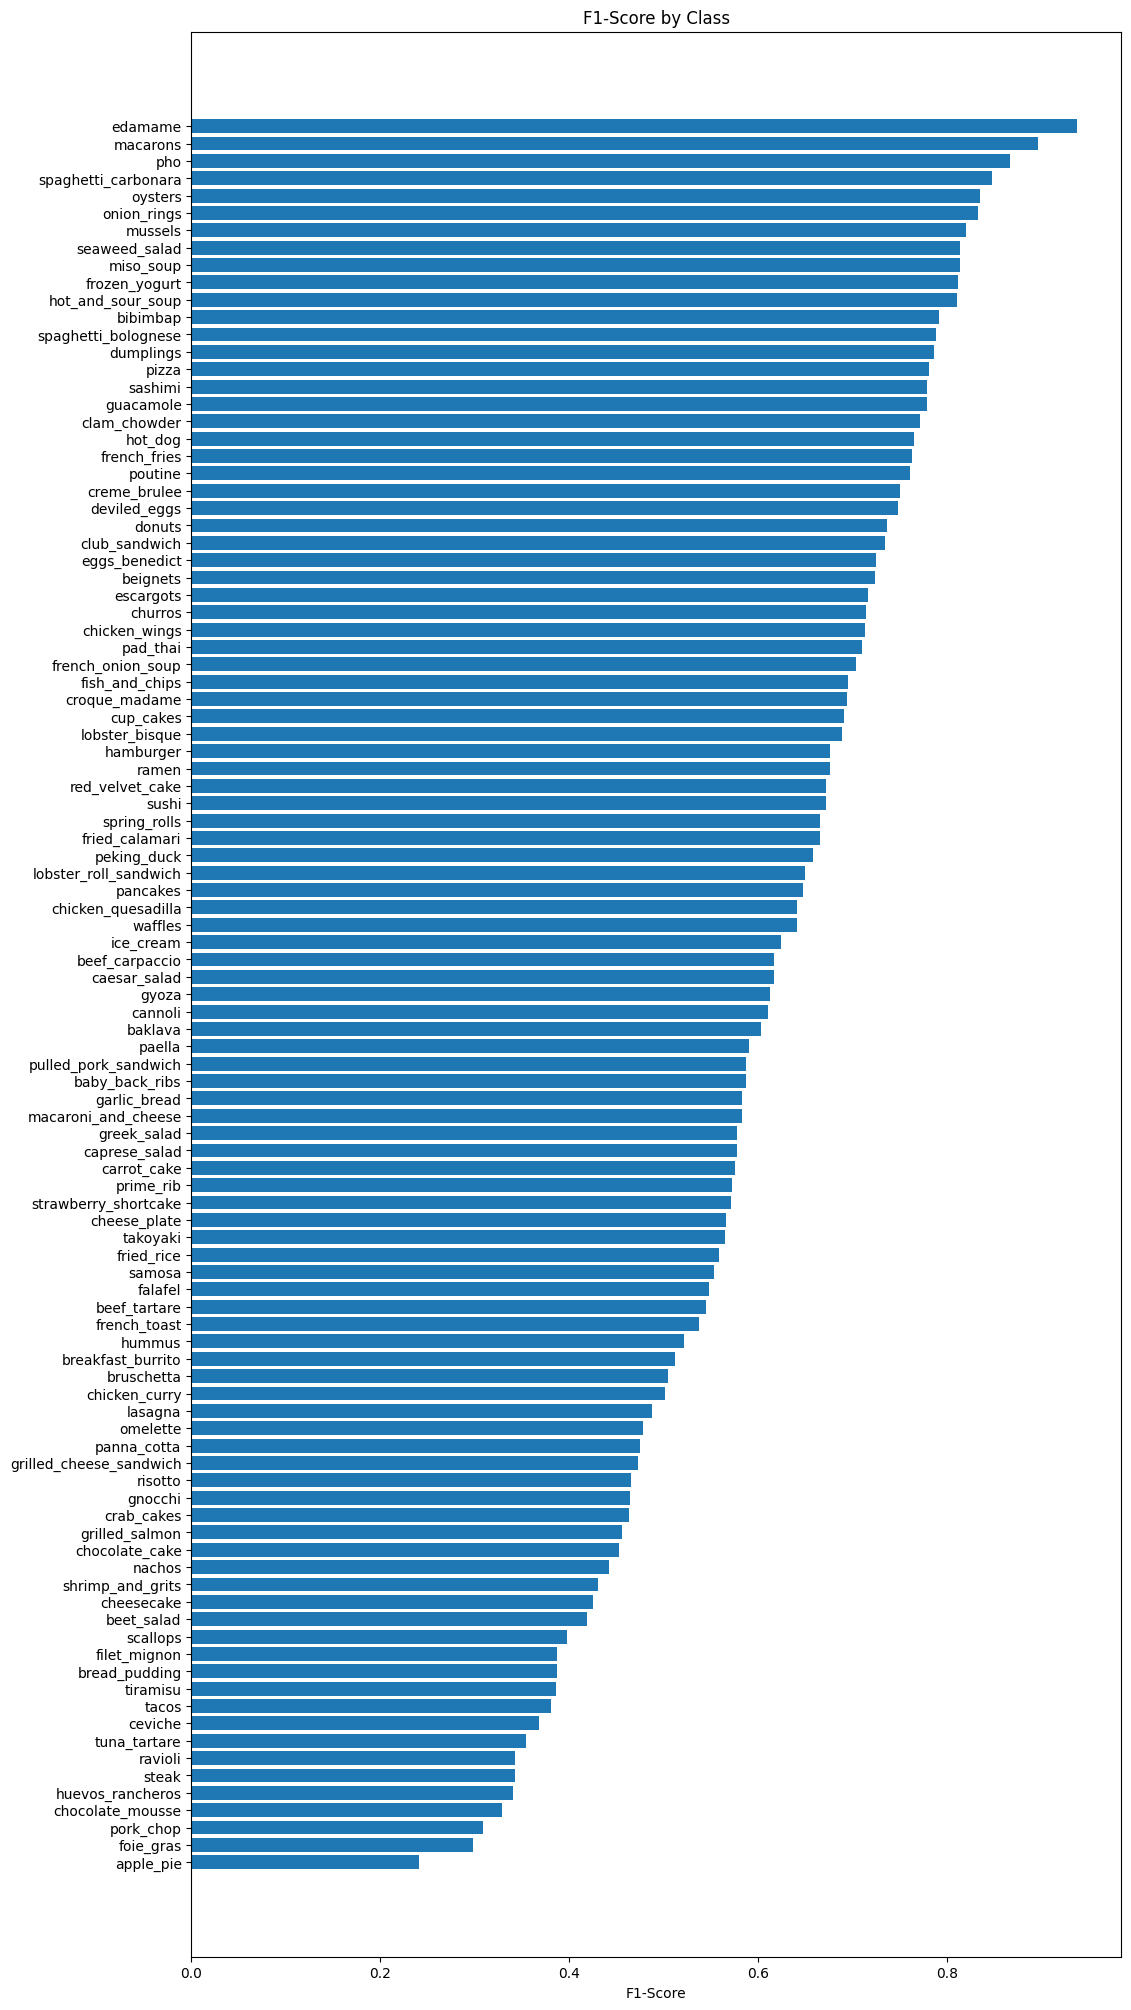

In [56]:
import matplotlib.pyplot as plt

fig, ax =plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-Score')
ax.set_title('F1-Score by Class')
ax.invert_yaxis()


## Loading and preparing images

In [73]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  '''
  Reads in an image and converts it into a tensor of (img_shape,img_shape,color_channels=3)
  '''
  img = tf.io.read_file(filename)

  img= tf.io.decode_image(img,channels=3)

  img=tf.image.resize(img,[img_shape,img_shape])

  if scale:
    return img/255.
  
  return img

1/1 [==============================] - 0s 30ms/step


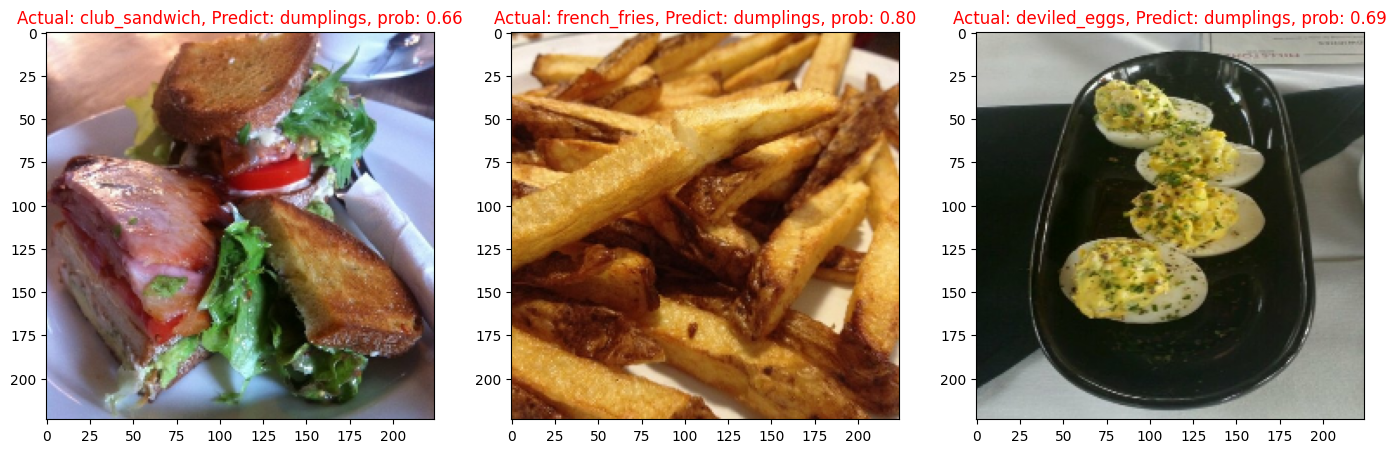

In [97]:
import os
import random

plt.figure(figsize=(17,10))

for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + '/' + class_name))
  filepath = test_dir +'/'+ class_name +'/' + filename

  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)


  pred_prob = model.predict(img_expanded)
  pred_class = class_names[preds_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)

  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  
  plt.title(f'Actual: {class_name}, Predict: {pred_class}, prob: {pred_prob.max():.2f}',c=title_color)



In [103]:
filepaths=[]
for filepath in test_data.list_files('101_food_classes_10_percent/test/*/*.jpg',shuffle=False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [105]:
import pandas as pd
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': preds_classes,
                        'pred_conf': preds_probs.max(axis=1),
                        'y_true_classname': [class_names[i] for i in y_labels],
                       ' y_pred_classname': [class_names[i] for i in preds_classes]})

In [106]:
pred_df

img_path  y_true  y_pred   
0      b'101_food_classes_10_percent\\test\\apple_pie...       0      52  \
1      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3      b'101_food_classes_10_percent\\test\\apple_pie...       0      80   
4      b'101_food_classes_10_percent\\test\\apple_pie...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25246  b'101_food_classes_10_percent\\test\\waffles\\...     100      16   
25247  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25248  b'101_food_classes_10_percent\\test\\waffles\\...     100      94   
25249  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847419        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367903        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972824          waffles               waffles  
25246   0.878027          waffles          cheese_plate  
25247   0.537898          waffles               waffles  
25248   0.501949          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [107]:
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df

img_path  y_true  y_pred   
0      b'101_food_classes_10_percent\\test\\apple_pie...       0      52  \
1      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
2      b'101_food_classes_10_percent\\test\\apple_pie...       0       0   
3      b'101_food_classes_10_percent\\test\\apple_pie...       0      80   
4      b'101_food_classes_10_percent\\test\\apple_pie...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25246  b'101_food_classes_10_percent\\test\\waffles\\...     100      16   
25247  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   
25248  b'101_food_classes_10_percent\\test\\waffles\\...     100      94   
25249  b'101_food_classes_10_percent\\test\\waffles\\...     100     100   

       pred_conf y_true_classname      y_pred_classname  pred_correct  
0       0.847419        apple_pie                 gyoza         False  
1       0.964017        apple_pie             apple_pie          True  
2       0.959259        apple_pie             apple_pie          True  
3       0.658607        apple_pie  pulled_pork_sandwich         False  
4       0.367903        apple_pie             prime_rib         False  
...          ...              ...                   ...           ...  
25245   0.972824          waffles               waffles          True  
25246   0.878027          waffles          cheese_plate         False  
25247   0.537898          waffles               waffles          True  
25248   0.501949          waffles  strawberry_shortcake         False  
25249   0.690629          waffles               waffles          True  

[25250 rows x 7 columns]

In [109]:
top_wrong = pred_df[pred_df['pred_correct']==False].sort_values('pred_conf', ascending=False)[:100]
top_wrong

img_path  y_true  y_pred   
21810  b'101_food_classes_10_percent\\test\\scallops\...      87      29  \
231    b'101_food_classes_10_percent\\test\\apple_pie...       0     100   
15359  b'101_food_classes_10_percent\\test\\lobster_r...      61      53   
23539  b'101_food_classes_10_percent\\test\\strawberr...      94      83   
21400  b'101_food_classes_10_percent\\test\\samosa\\3...      85      92   
...                                                  ...     ...     ...   
8763   b'101_food_classes_10_percent\\test\\escargots...      35      41   
2663   b'101_food_classes_10_percent\\test\\bruschett...      10      61   
7924   b'101_food_classes_10_percent\\test\\donuts\\3...      31      29   
18586  b'101_food_classes_10_percent\\test\\peking_du...      74      39   
3519   b'101_food_classes_10_percent\\test\\carrot_ca...      14      21   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997169              escargots      french_onion_soup         False  
2663    0.997055             bruschetta  lobster_roll_sandwich         False  
7924    0.997020                 donuts              cup_cakes         False  
18586   0.996884            peking_duck              foie_gras         False  
3519    0.996842            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

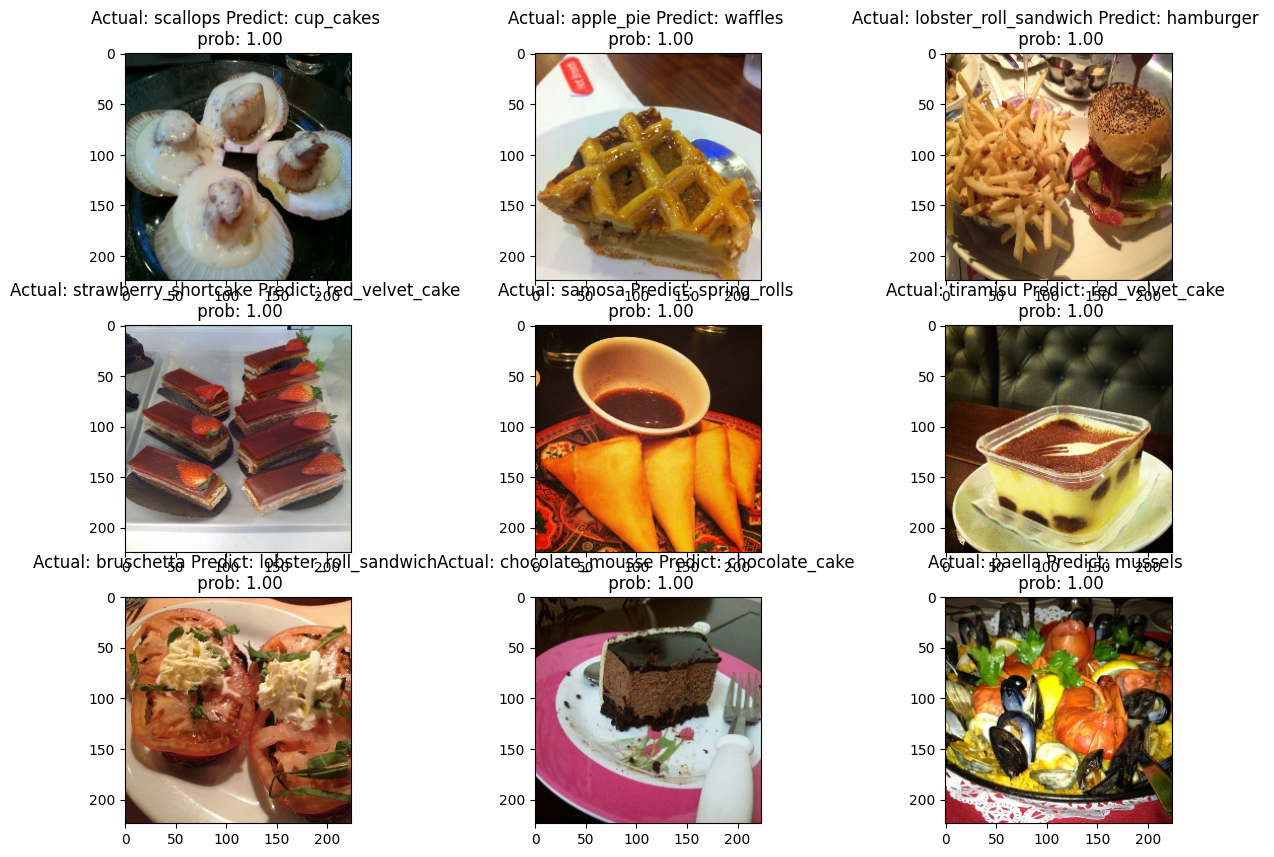

In [118]:
images_to_view = 9
start_index = 0

plt.figure(figsize=(15,10))

for i, row in enumerate(top_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale = False)

  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row

  plt.imshow(img/255.)
  plt.title(f'Actual: {y_true_classname} Predict: {y_pred_classname} \n prob: {pred_prob:.2f}',)
